In [28]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rania121","key":"214a81c41cafd2a04cf2b029606405a5"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -dnikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 81% 254M/312M [00:00<00:00, 741MB/s] 
100% 312M/312M [00:00<00:00, 795MB/s]


In [6]:
!unzip brain-tumor-segmentation.zip


Streaming output truncated to the last 5000 lines.
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         

In [57]:
import os
import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

In [8]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_data(image_dir, mask_dir):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=-1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, Y = load_data("images", "masks")


In [13]:
print(X.shape)
print(Y.shape)

(3064, 128, 128, 1)
(3064, 128, 128, 1)


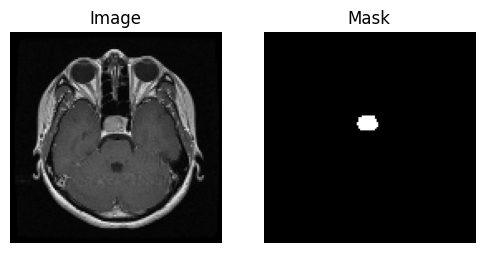

In [16]:
def show_sample(index):
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(X[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(Y[index].squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

show_sample(3)


In [36]:
X_trainval, X_test, Y_trainval, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.1, random_state=42)


In [37]:
# Dice loss
def dice_loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return 1 - (2. * intersection + 1e-7) / (K.sum(y_true) + K.sum(y_pred) + 1e-7)

# Dice score metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# IOU metric
def iou_metric(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)


In [47]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    b = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    b = Conv2D(1024, 3, activation='relu', padding='same')(b)
    b = Dropout(0.5)(b)

    # Decoder
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, c4])
    c5 = Conv2D(512, 3, activation='relu', padding='same')(u1)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u2)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u3)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u4)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs, outputs)
    return model


In [58]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True )
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [60]:
model = unet_model()

model.compile(optimizer='adam', loss=dice_loss , metrics=[dice_coef, iou_metric])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50,batch_size=32, callbacks=[early_stop, lr_scheduler])


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 140s 988ms/step - dice_coef: 0.1104 - iou_metric: 0.0591 - loss: 0.8896 - val_dice_coef: 0.0353 - val_iou_metric: 0.0180 - val_loss: 0.9658 - learning_rate: 0.0010
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 47s 480ms/step - dice_coef: 0.2615 - iou_metric: 0.1521 - loss: 0.7385 - val_dice_coef: 0.0027 - val_iou_metric: 0.0013 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 40s 464ms/step - dice_coef: 0.4838 - iou_metric: 0.3215 - loss: 0.5162 - val_dice_coef: 5.8884e-04 - val_iou_metric: 2.4333e-04 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - dice_coef: 0.5776 - iou_metric: 0.4084 - loss: 0.4225
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
78/78 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - dice_coef: 0.5775 - iou_metric: 0.4083 - loss: 0.4226 - val_dice_coef: 5.1283e-04 - val_iou_metric: 2.5121e-04 - val_loss: 0.9995 - learning_rate: 0.0010
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


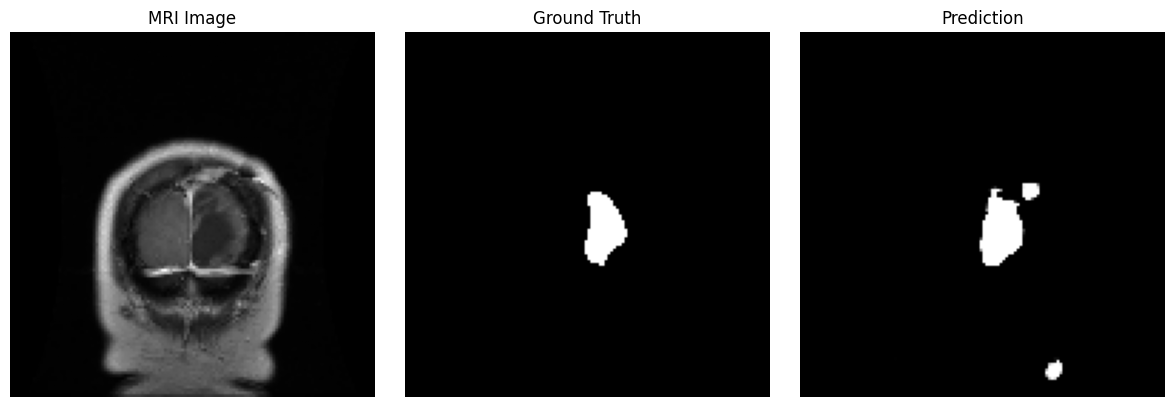

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


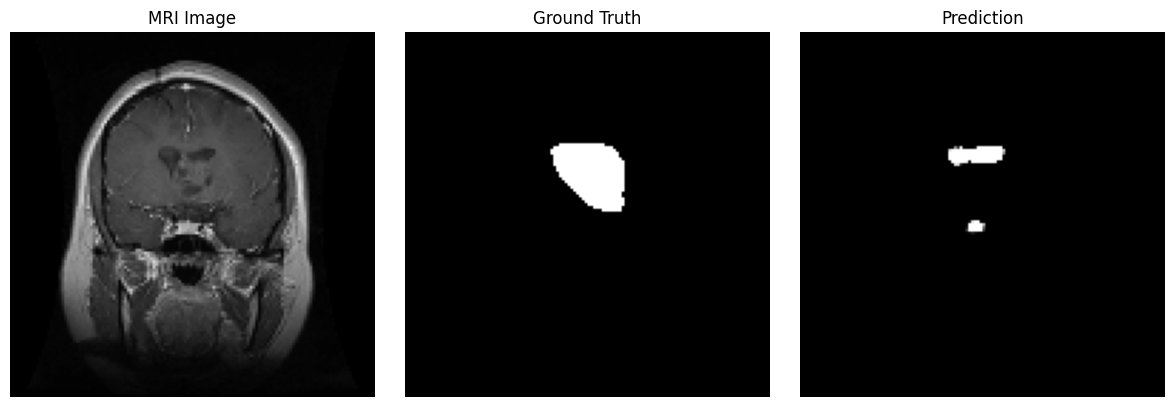

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


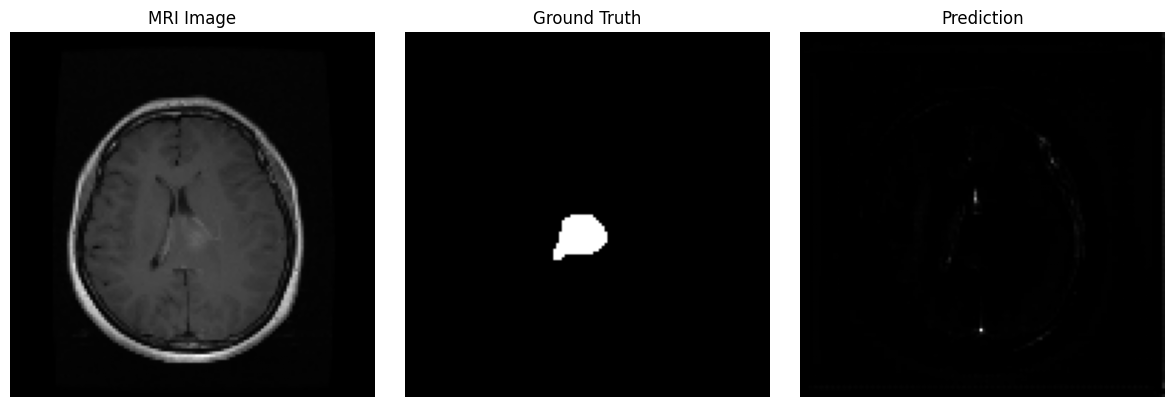

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


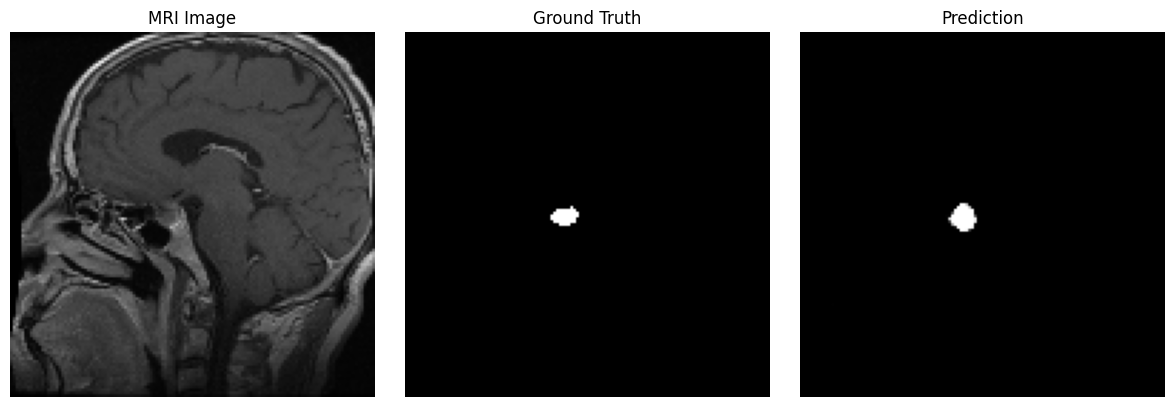

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


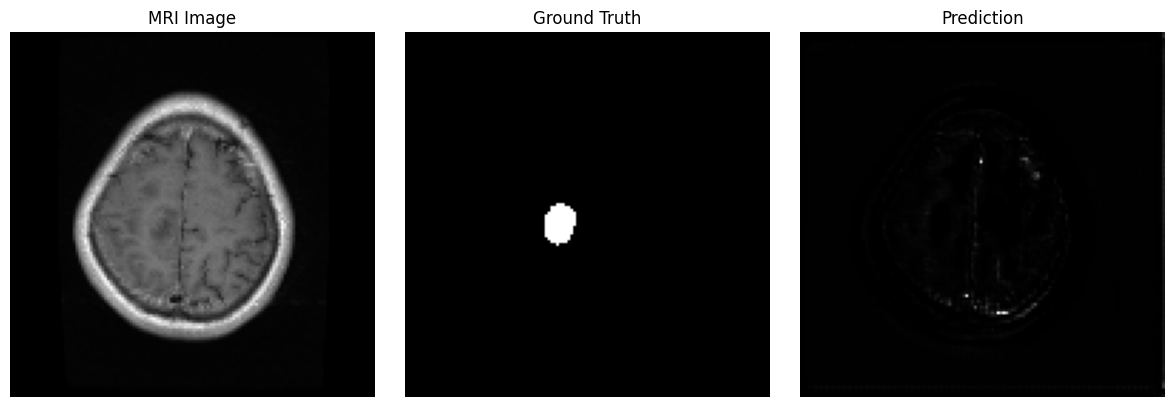

In [61]:
num_samples = 5

for i in range(num_samples):
    pred = model.predict(np.expand_dims(X_val[i], axis=0))[0]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [62]:
val_dice = history.history['val_dice_coef'][-1]
val_iou = history.history['val_iou_metric'][-1]

print(f"Final Validation Dice Coefficient: {val_dice:.4f}")
print(f"Final Validation IoU: {val_iou:.4f}")


Final Validation Dice Coefficient: 0.7335
Final Validation IoU: 0.5810


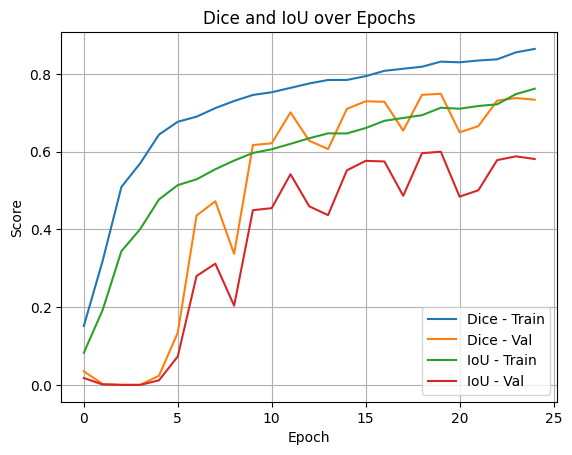

In [65]:
plt.plot(history.history['dice_coef'], label='Dice - Train')
plt.plot(history.history['val_dice_coef'], label='Dice - Val')
plt.plot(history.history['iou_metric'], label='IoU - Train')
plt.plot(history.history['val_iou_metric'], label='IoU - Val')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Dice and IoU over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
test_results = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")
print(f"Test IoU: {test_results[2]:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - dice_coef: 0.7688 - iou_metric: 0.6263 - loss: 0.2306
Test Loss: 0.2186
Test Dice Coefficient: 0.7781
Test IoU: 0.6390
